In [3]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 0.1  #non-IID

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# ---- Extreme NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Client 0 train samples: 2278
Client 1 train samples: 670
Client 2 train samples: 1173
Client 3 train samples: 1591
Client train: 1823, test: 455
Client train: 536, test: 134
Client train: 939, test: 234
Client train: 1273, test: 318
Client 0:
  glioma: 926 samples
  meningioma: 53 samples
  notumor: 0 samples
  pituitary: 844 samples
------------------------------
Client 1:
  glioma: 125 samples
  meningioma: 411 samples
  notumor: 0 samples
  pituitary: 0 samples
------------------------------
Client 2:
  glioma: 0 samples
  meningioma: 609 samples
  notumor: 7 samples
  pituitary: 323 samples
------------------------------
Client 3:
  glioma: 1 samples
  meningioma: 1 samples
  notumor: 1270 samples
  pituitary: 1 samples
------------------------------
Client 0:
  Training set:
    glioma: 926 samples
    meningioma: 53 samples
    notumor: 0 samples
    pituitary: 844 samples
  Testing set:
    glioma: 238 samples
    meningioma: 12 samples
  

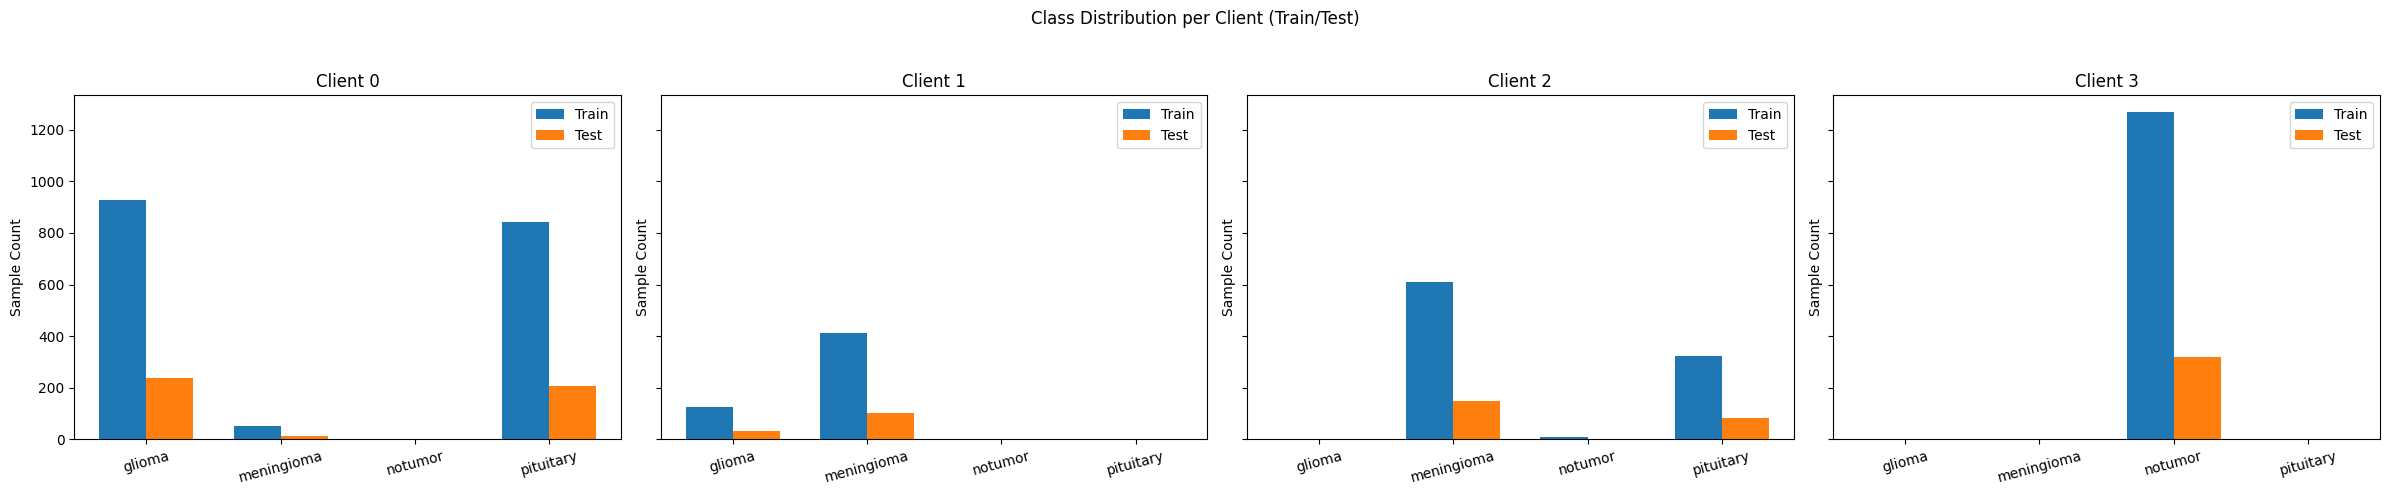

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)
